# PROJECT: predict insurance cost of patients

dataset from https://www.kaggle.com/datasets/mirichoi0218/insurance

Notebook author: Fabrizio Bernardi

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor 
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge, Lasso
from sklearn import metrics
import seaborn as sb
from sklearn.metrics import mean_squared_error as mse 


Read dataset and look for missing values:

In [2]:
df = pd.read_csv('C:/Users/Fabrizio/Desktop/datasets_ML/insurance.csv')



In [3]:
df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [4]:
df.isna().sum()

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64

In [5]:
df.shape

(1338, 7)

Convert categorical variables into numerical ones:

In [6]:
label_encoder = LabelEncoder()

sex_encoded = label_encoder.fit_transform(df['sex'])

smoker_encoded = label_encoder.fit_transform(df['smoker'])

region_encoded = label_encoder.fit_transform(df['region'])

#df = df.drop(columns = ['sex','smoker','region'])

df['sex_encoded'] = sex_encoded

df['smoker_encoded'] = smoker_encoded

df['region_encoded'] = region_encoded

df.head()

,age,sex,bmi,children,smoker,region,charges,sex_encoded,smoker_encoded,region_encoded
0,19,female,27.900,0,yes,southwest,16884.92400,0,1,3
1,18,male,33.770,1,no,southeast,1725.55230,1,0,2
2,28,male,33.000,3,no,southeast,4449.46200,1,0,2
3,33,male,22.705,0,no,northwest,21984.47061,1,0,1
4,32,male,28.880,0,no,northwest,3866.85520,1,0,1


In [8]:
charges_male = df[df['sex'] == 'male']['charges']

charges_female = df[df['sex'] == 'female']['charges']



**Question**: does the gender constitute a difference in the insurance charge? Let's visualize charges into the two cases:

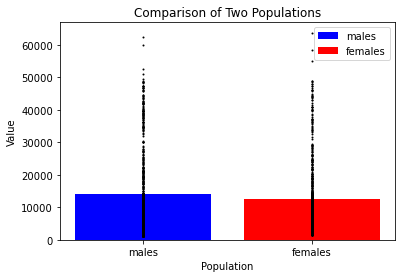

13956.751177721886 12569.57884383534


In [9]:

# Plot bar plots side by side
bars =plt.bar([1, 2], [np.mean(charges_male), np.mean(charges_female)], tick_label=['males', 'females'], label='Mean', color=['blue', 'red'])

# Plot individual data points
for i, data in enumerate([charges_male, charges_female]):
    plt.scatter([i+1]*len(data), data, color ='black', s=1)  # Adjust the value of 's'
# Add labels and legend
plt.xlabel('Population')
plt.ylabel('Value')
plt.title('Comparison of Two Populations')

# Create legend handles
handles = [bars[0], bars[1]]
labels = ['males', 'females']
plt.legend(handles, labels)
# Show plot
plt.show()

print(np.mean(charges_male), np.mean(charges_female))

It doesn't seem like the gender plays a relevant role. Let's validate it with a statistical test. We can use t-test under gaussianity hypothesis:

In [10]:
from scipy.stats import shapiro
stat, p = shapiro(charges_male)

# Interpret the results
alpha = 0.05
print("Shapiro-Wilk Test for male charges:")
print("Statistic:", stat)
print("p-value:", p)


stat, p = shapiro(charges_female)

# Interpret the results
alpha = 0.05
print("Shapiro-Wilk Test for female charges:")
print("Statistic:", stat)
print("p-value:", p)

Shapiro-Wilk Test for male charges:
Statistic: 0.8228140473365784
p-value: 1.1788512419005296e-26
Shapiro-Wilk Test for female charges:
Statistic: 0.8053942322731018
p-value: 1.830527656441053e-27


Since data are non gaussian, we use nonparametric test:

In [11]:
from scipy.stats import mannwhitneyu

stat, p = mannwhitneyu(charges_male, charges_female)

# Interpret the results
alpha = 0.05
print("Mann-Whitney U Test:")
print("Statistic:", stat)
print("p-value:", p)

Mann-Whitney U Test:
Statistic: 226208.0
p-value: 0.7286510894470093


As expected, no significant difference has been found.
Moving on with insurance predictions, let's drop categorical columnsand look for highly correlated variables:

In [12]:
df = df.drop(columns = ['sex','smoker','region'])

df.head()

,age,bmi,children,charges,sex_encoded,smoker_encoded,region_encoded
0,19,27.900,0,16884.92400,0,1,3
1,18,33.770,1,1725.55230,1,0,2
2,28,33.000,3,4449.46200,1,0,2
3,33,22.705,0,21984.47061,1,0,1
4,32,28.880,0,3866.85520,1,0,1


In [13]:
X = df.drop(columns = ['charges']).values
y = df['charges'].values

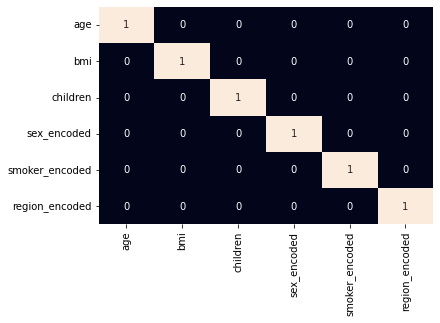

In [14]:
sb.heatmap(df.drop(columns = ['charges']).corr() > .8 ,annot=True, cbar=False)

plt.show()

As there are no highly correlated variables, we can proceed considering all features, normalizing data and splitting into train and test sets:

In [15]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=.2,random_state=12)

scaler = StandardScaler()

X_train = scaler.fit_transform(X_train) 

X_test = scaler.transform(X_test)

print(X_train.shape)

print(X_test.shape)

print(y_test.shape)



(1070, 6)
(268, 6)
(268,)


Let's train linear regression models (with and without regularization) and random forest model. Before that, however, let's find the optimal regularization parameter for the Ridge regression:

In [34]:
alpha_vec = np.arange(0.1,50,0.2)

errors_ridge = []

for alpha in alpha_vec:
    
    curr_model = Ridge(alpha=alpha)
    
    curr_model.fit(X_train,y_train)
    
    errors_ridge.append(mse(curr_model.predict(X_test),y_test))
    
best_alpha = alpha_vec[np.where(errors_ridge == np.min(errors_ridge))]

print("Best regularization is alpha = ", best_alpha)
    

Best regularization is alpha =  [18.5]


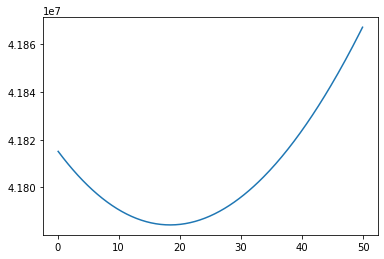

In [33]:
plt.plot(alpha_vec,errors_ridge)

In [35]:
models = [LinearRegression(),Ridge(alpha=best_alpha),RandomForestRegressor()]

mse_train = []

mse_test = []

predictions = []

for model in models:
    
    model.fit(X_train,y_train)
    
    predictions.append(model.predict(X_test))
    
    mse_train.append(mse(model.predict(X_train), y_train))
    
    mse_test.append(mse(model.predict(X_test), y_test))
    

print( " +++ TRAIN / VAL ERROR LINEAR REGRESSION: ",mse_train[0], "    ", mse_test[0] ,"+++" )

print( " +++ TRAIN / VAL ERROR RIDGE REGRESSION: ",mse_train[1], "    ", mse_test[1] ,"+++" )

print( " +++ TRAIN / VAL ERROR RANDOM FOREST: ",mse_train[2], "    ", mse_test[2] ,"+++" )

 +++ TRAIN / VAL ERROR LINEAR REGRESSION:  35257440.33528014      41815438.3426143 +++
 +++ TRAIN / VAL ERROR RIDGE REGRESSION:  35290382.52292379      41784346.75559408 +++
 +++ TRAIN / VAL ERROR RANDOM FOREST:  3415740.9590467317      25420888.597261216 +++


Text(0.5, 1.0, 'Predictions with Random forest Regression')

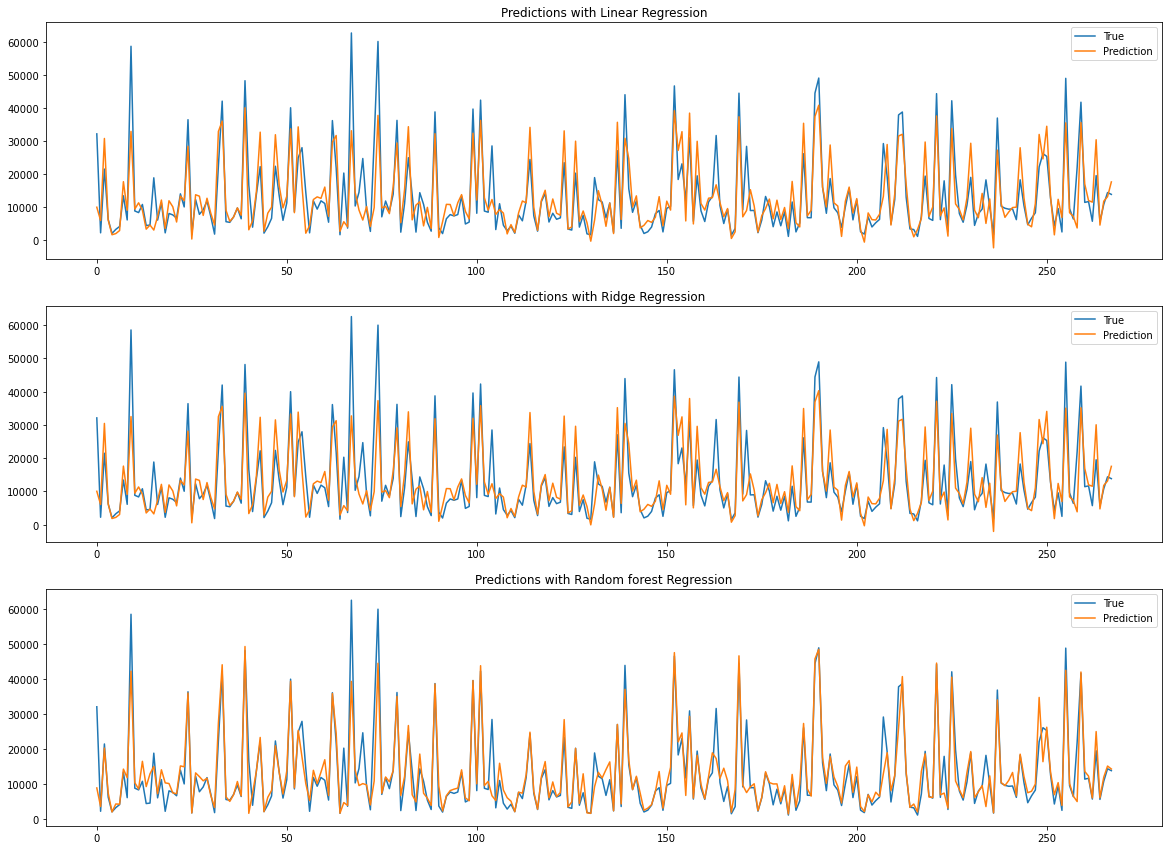

In [37]:
plt.figure(figsize=(20, 20))


plt.subplot(4,1,1)
plt.plot(y_test,label='True')

plt.plot(predictions[0],label='Prediction')
plt.legend()
plt.title('Predictions with Linear Regression')

plt.subplot(4,1,2)
plt.plot(y_test,label='True')

plt.plot(predictions[1],label='Prediction')
plt.legend()
plt.title('Predictions with Ridge Regression')


plt.subplot(4,1,3)
plt.plot(y_test,label='True')

plt.plot(predictions[2],label='Prediction')
plt.legend()
plt.title('Predictions with Random forest Regression')





**Conclusions**: the two linear regression models perform in a similar way. The best model (in terms of mse) is the random forest, as confirmed by visual inspection comparing true and predicted charges.